# BARB API Demo: The audiences by time endpoint

In this demo of the audiences by time endpoint we will:

1. Gain access to the API by requesting an access token
2. Query the API, requesting audience sizes for live viewing for BBC 1 on 15th Oct
3. Reshape the data into a pandas dataframe
4. Use the data to explore how different age groups watch the station at different times of day and how this varies by region.

## Set up the python environment

In [ ]:
import requests
import numpy as np
import json
import pandas as pd
import plotly.express as px
import plotly.io as pio
pio.renderers.default = "jupyterlab"

## Get the access token

This code uses your account details (substitute them in) to get an access token from the API

In [2]:
creds = {"email": "barb@thinkbluehat.com", "password": "Ajsvw&8KLE4k3vHg"}
token_request_url = "https://dev.barb-api.co.uk/api/v1/auth/token/"
response = requests.post(token_request_url, data = creds)
access_token = json.loads(response.text)['access']

## Get data from the API

The access token is then used to query the API.

In [3]:
head = {'Authorization': 'Bearer {}'.format(access_token)}
api_url = "https://dev.barb-api.co.uk/api/v1/audiences_by_time/"

# The query parameters
params = {"min_transmission_date": "2022-10-25","max_transmission_date":"2022-10-25",
          "time_period_length":15,"viewing_status":"live", "station_code": 10}

# Query the API and turn the response into json
response = requests.get(url = api_url,headers=head, params=params)
api_data = json.loads(response.text)

How many events have been returned?

In [4]:
print("{} transmission events".format(len(api_data["events"])))

4581 transmission events


Note if there had been over 5000 events (the limit for a single API call) we would have needed to make several calls to the API using the `x_next` attribute.

## Reshape the data as a pandas dataframe

We now restructure the data as a pandas dataframe. The json data is highly flexible. We are choosing the parts of the data that we need and turning them into a table.

In [5]:
# Loop through the events and then the audiences within the events
bbc_1 = []
for e in api_data['events']:
    for v in e['audience_views']:
        bbc_1.append({'panel_region': e['panel']['panel_region'],
                                    'transmission_time_period': e['transmission_time_period']['transmission_time_period_start']['standard_activity_start_date_time'],
                                    'audience_code': v['audience_code'],
                                    'size_in_hundreds': v['size_in_hundreds']})
# Convert the result into a data frame
bbc_1 = pd.DataFrame(bbc_1)

# Format the transmission_time_period as a pandas datetime
bbc_1['transmission_time_period'] = pd.to_datetime(bbc_1['transmission_time_period'])

# Add the audience category names. We have a temporary problem with duplicates in this data set hence the dropping of duplicates.
audience_categories_df = pd.DataFrame(api_data['audience_categories']).drop_duplicates(subset=['audience_code'])
bbc_1 = bbc_1.merge(audience_categories_df, on = "audience_code").drop("audience_code", axis=1)
bbc_1.head()

,panel_region,transmission_time_period,size_in_hundreds,audience_name,audience_target_size_hundreds
0,"London - ITV,C4,ITV Breakfast",2022-10-25 02:00:00,302,All Homes,5037
1,"London - ITV,C4,ITV Breakfast",2022-10-25 02:15:00,133,All Homes,5037
2,"London - ITV,C4,ITV Breakfast",2022-10-25 02:30:00,109,All Homes,5037
3,"London - ITV,C4,ITV Breakfast",2022-10-25 02:45:00,112,All Homes,5037
4,"London - ITV,C4,ITV Breakfast",2022-10-25 03:00:00,193,All Homes,5037


## Inspect the data

Checking what is in the data by looking at the average audience size for each audience category and panel.

In [6]:
bbc_1.groupby(["audience_name", "panel_region" ])["size_in_hundreds"].mean().round(1).unstack().fillna(0)

panel_region,BBC East Region,BBC London,BBC Midlands East,BBC Midlands West,BBC Network,BBC North East & Cumbria,BBC North West Region,BBC Scotland Region,BBC South East,BBC South Region,...,South East Macro,South West,"South, South East & Channel Is","Ulster - ITV,C4,ITV Breakfast",Wales,Wales & West Macro,West,West Macro,Yorkshire,Yorkshire/North East Macro
audience_name,,,,,,,,,,,,,,,,,,,,,
"ABC1 Adults, Lightest Third",30.8,95.7,49.6,50.5,389.1,58.5,69.1,51.3,62.0,39.3,...,108.5,22.2,92.6,8.3,22.8,29.4,20.5,50.6,69.7,44.6
Adults 16-24,36.6,91.3,35.7,27.0,211.1,68.5,27.3,61.8,33.2,174.8,...,160.2,8.6,164.0,8.5,142.9,56.9,12.1,62.7,31.4,18.1
Adults 16-34,63.8,210.3,47.9,74.2,568.8,73.0,116.9,62.0,43.3,221.0,...,192.2,19.6,186.4,21.5,94.6,74.2,28.2,92.9,70.0,58.8
"Adults 16-34, Lightest Third",9.5,62.0,0.0,0.0,55.5,44.9,6.5,19.7,0.0,4.0,...,12.6,2.7,12.4,2.3,9.0,8.7,4.9,8.8,10.5,6.5
Adults 18-20,27.3,0.0,26.5,8.0,65.2,0.0,0.0,8.7,0.0,53.4,...,45.0,3.3,63.8,4.5,149.0,65.1,4.7,66.2,0.0,5.4
Adults 21-24,33.7,52.3,41.8,41.0,139.7,49.0,0.0,60.6,23.0,207.6,...,144.6,5.7,212.4,4.8,17.0,11.5,8.5,15.2,31.4,14.8
Adults 35-44,94.2,224.7,58.3,59.4,582.3,54.7,36.6,78.8,54.5,69.1,...,178.7,23.8,119.1,23.6,54.3,71.9,29.7,93.5,80.7,65.3
Adults 45-49,80.9,129.1,76.3,101.0,723.5,54.8,66.6,99.3,96.3,126.3,...,184.3,22.8,144.2,23.6,57.6,68.0,34.2,86.9,85.6,83.1
Adults 45-54,104.7,284.1,107.6,159.0,1653.5,97.7,135.3,216.2,183.0,211.1,...,330.6,53.6,251.2,53.4,113.6,182.8,75.3,230.9,144.5,197.1


## Age groups watching BBC 1 over a day

Having created the dataframe we can now analyse it in various ways. Here we look at how the audience size changes over the day for various age bands.

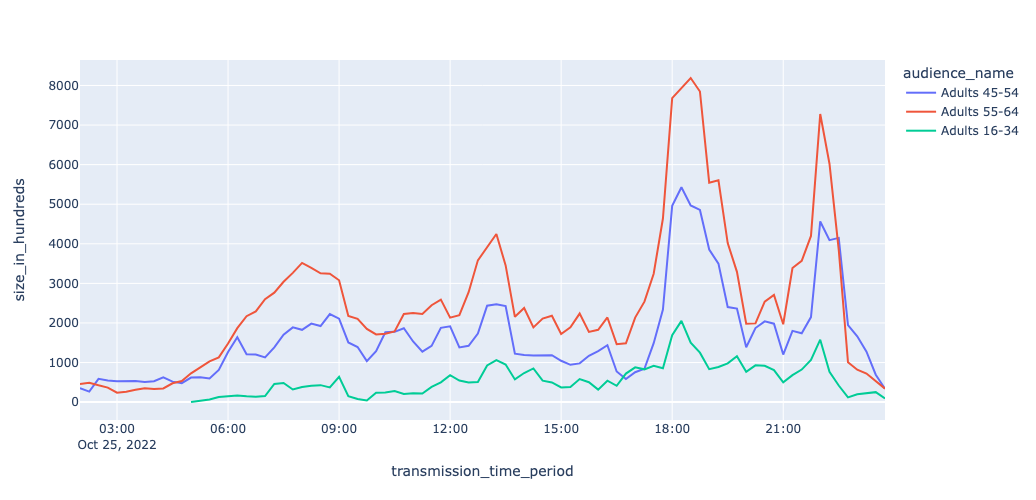

In [7]:
age_bands = ["Adults 16-34", "'Adults 35-44", "Adults 45-54", "Adults 55-64"]
demog = bbc_1[(bbc_1["audience_name"].isin(age_bands)) & (bbc_1["panel_region"]=="BBC Network")]
px.line(demog, x="transmission_time_period", y="size_in_hundreds", color='audience_name', height=500)

## How does this vary by region

This might be more interesting if we:

1. Look penetration of the target audience
2. Compare this across the BBC panel regions

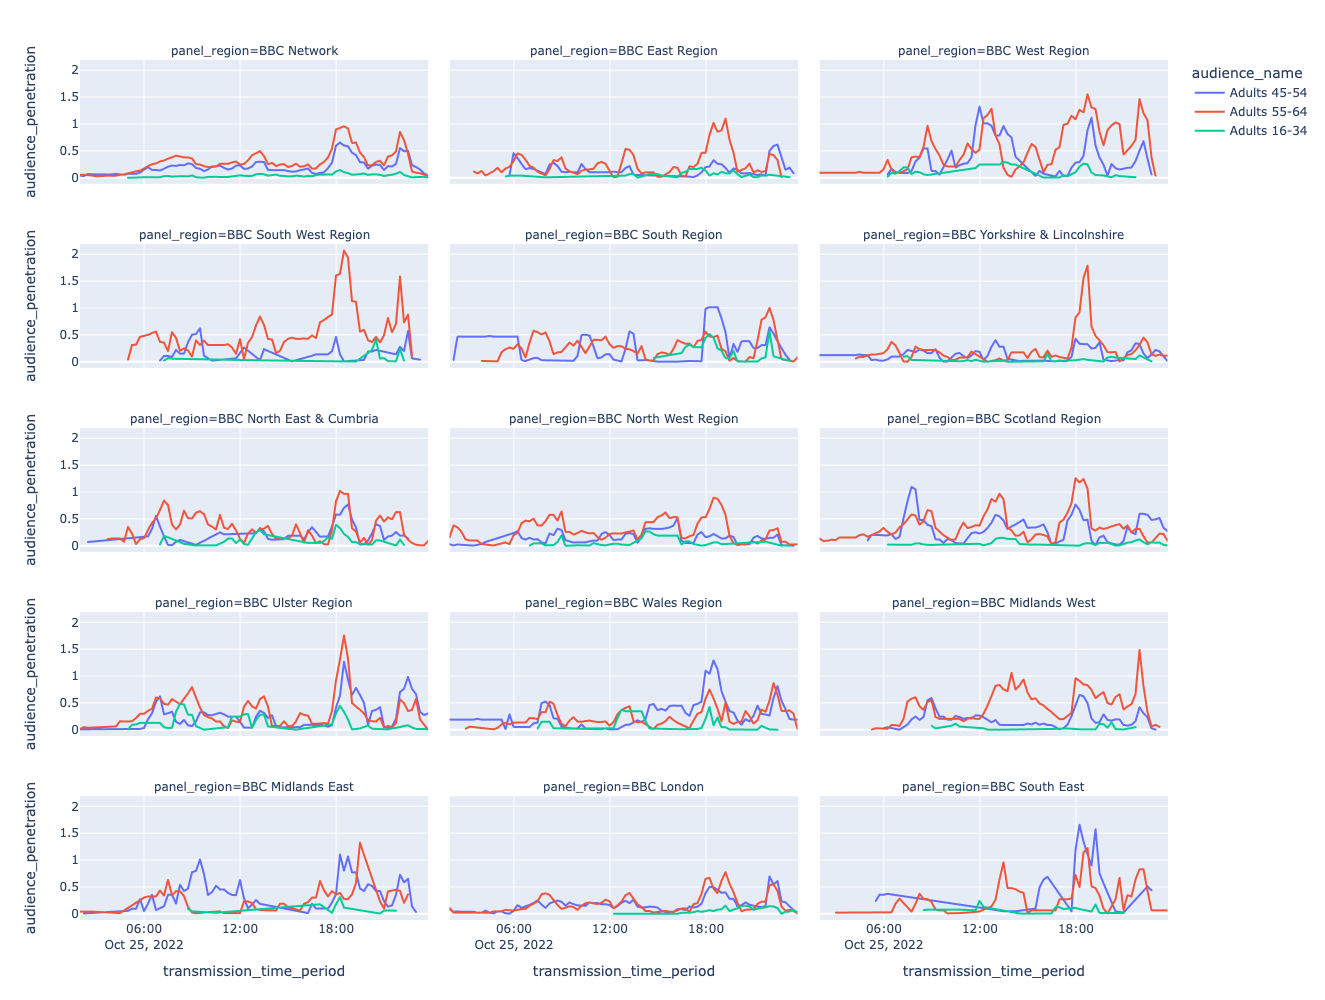

In [9]:
demog = bbc_1[(bbc_1["audience_name"].isin(age_bands)) & (bbc_1["panel_region"].str[:3]=="BBC")]

# There is temp fix here as the target size is out by a factor of 10
demog = demog.assign(audience_penetration = demog["size_in_hundreds"]/(10*demog["audience_target_size_hundreds"]))

# Plot the chart
px.line(demog, x="transmission_time_period", y="audience_penetration", color='audience_name', facet_col = "panel_region", 
           facet_col_wrap=3, height = 1000)